In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations

In [27]:
Stage=3
folder_name='experiment and result stage'+str(Stage)
Dataset="Baseline Mnist" #if baseline then Basline .../...
baseline='3*3'

if baseline:
  x=Dataset+" "+baseline
  filename="Copy of " + x + "_result.csv"
else:
  filename="Copy of " + Dataset + "_result.csv"

methods=['deeplift', 'integrated_gradients']
method='deeplift'
flops_dict = {"branch1": 56.448, "branch2": 56.448, "branch3": 56.448, "totalFLOPS": 365}
end_epoch=0

In [28]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed data/'
print(save_folder)

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline Mnist/Copy of Baseline Mnist 3*3_result.csv
/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline Mnist/processed data/


In [29]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [30]:
def preprocess_dataframe(df, flops_dict):
    df.rename(columns={'branch1.0': 'branch1', 'branch2.0': 'branch2', 'branch3.0': 'branch3', 'branch4.0': 'branch4'}, inplace=True)

    # Add FLOPS columns
    for col, value in flops_dict.items():
        df[col+"FLOPS"] = value
    return df
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [31]:
def normalize_feature_attribution(df, threshold=70):
    layers=['branch1','branch2','branch3','branch4']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']


    df.drop(['sum_feature_attr','branch1','branch2','branch3','branch4'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

In [32]:
normalized_df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS,norm_branch1,norm_branch2,norm_branch3,norm_branch4,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.666667,97.29,deeplift,0,56.448,56.448,56.448,365,0.398606,0.228181,0.113520,0.259693,97.29
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.666667,97.29,integrated_gradients,0,56.448,56.448,56.448,365,0.398894,0.227655,0.114484,0.258966,97.29
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.763333,97.15,deeplift,1,56.448,56.448,56.448,365,0.103137,0.319268,0.228451,0.349144,97.15
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.763333,97.15,integrated_gradients,1,56.448,56.448,56.448,365,0.103115,0.319767,0.228365,0.348753,97.15
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,93.765000,96.99,deeplift,2,56.448,56.448,56.448,365,0.201314,0.293604,0.192280,0.312802,96.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.346667,96.65,integrated_gradients,12,56.448,56.448,56.448,365,0.366320,0.238959,0.077386,0.317335,96.65
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.403333,96.81,deeplift,13,56.448,56.448,56.448,365,0.242149,0.056480,0.379055,0.322317,96.81
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.403333,96.81,integrated_gradients,13,56.448,56.448,56.448,365,0.242550,0.056633,0.377431,0.323386,96.81
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,94.101667,96.74,deeplift,14,56.448,56.448,56.448,365,0.396890,0.145570,0.033171,0.424369,96.74


get standard deviation for each layer's feature attribution

In [33]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1','norm_branch2','norm_branch3','norm_branch4']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [34]:
FA_SD.to_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")

In [35]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1,norm_branch2,norm_branch3,norm_branch4,...,std_norm_branch2,std_norm_branch3,std_norm_branch4,avg_std,train accuracy epoch0,test accuracy epoch0,branch1,branch2,branch3,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.265927,0.191644,0.215408,0.327021,...,0.068605,0.095008,0.046782,0.077826,94.418889,96.883333,56.448,56.448,56.448,365
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.303767,0.198446,0.248815,0.248972,...,0.079106,0.116803,0.041349,0.087189,94.054333,96.841333,56.448,56.448,56.448,365
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.315045,0.212900,0.268162,0.203892,...,0.081977,0.112542,0.032238,0.083671,93.305000,96.804000,56.448,56.448,56.448,365
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.314616,0.227807,0.277235,0.180342,...,0.069690,0.096496,0.027107,0.073131,92.145778,96.142000,56.448,56.448,56.448,365
4,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.182153,0.201422,0.178626,0.437799,...,0.055232,0.060813,0.018020,0.049595,94.606111,96.717333,56.448,56.448,56.448,365
5,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.210623,0.202730,0.189211,0.397437,...,0.055881,0.065933,0.026485,0.054400,94.548000,96.916667,56.448,56.448,56.448,365
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.259795,0.205592,0.221989,0.312625,...,0.063890,0.087177,0.037169,0.069016,94.214111,97.087333,56.448,56.448,56.448,365
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.298061,0.210351,0.255105,0.236484,...,0.074636,0.109483,0.034128,0.080373,93.475444,96.948000,56.448,56.448,56.448,365
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.165767,0.198833,0.176217,0.459183,...,0.054592,0.058053,0.016082,0.047400,94.463778,96.436000,56.448,56.448,56.448,365
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.189491,0.203437,0.185287,0.421784,...,0.054033,0.064699,0.020653,0.050479,94.542778,96.763333,56.448,56.448,56.448,365


# Graph

In [36]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['std_norm_branch1',	'std_norm_branch2',	'std_norm_branch3',	'std_norm_branch4', 'avg_std']

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


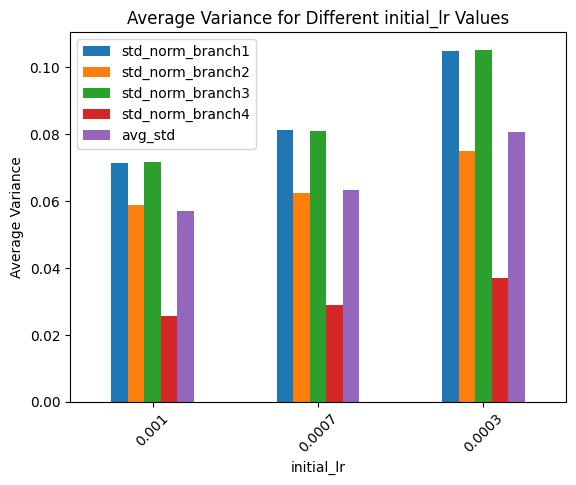

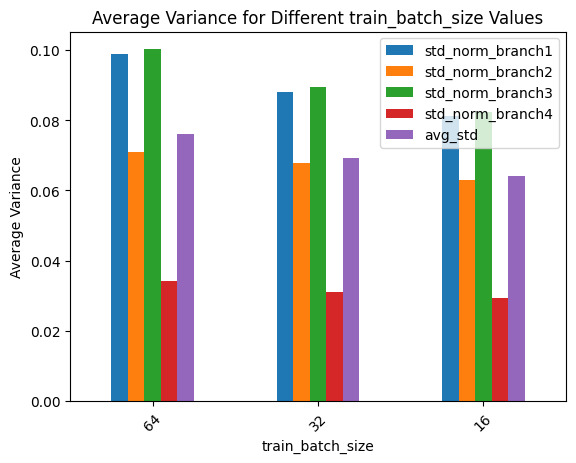

In [37]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bee_swarm_for_norm_fa(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['norm_branch1', 'norm_branch2', 'norm_branch3', 'norm_branch4']

    # Preparing data for plotting in long format
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var][variance_columns]
        subset = subset.melt(var_name='Branch', value_name='Variance')
        subset[hyperparam] = var
        plot_data = pd.concat([plot_data, subset])

    # Creating the bee swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x=hyperparam, y='Variance', hue='Branch', data=plot_data)
    plt.title(f'Bee Swarm Plot of Variances for Different {hyperparam} Values')
    plt.ylabel('Feature Attribution')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.legend(title='Branch')
    plt.show()


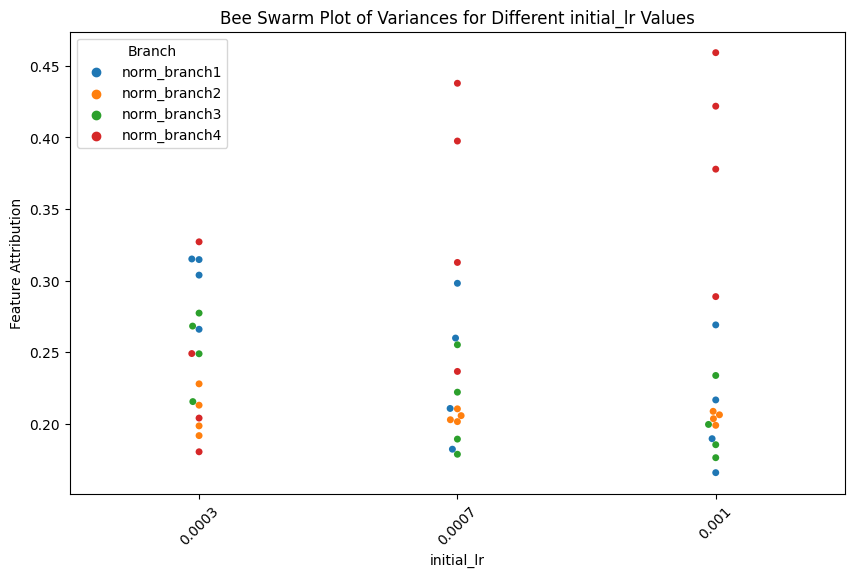

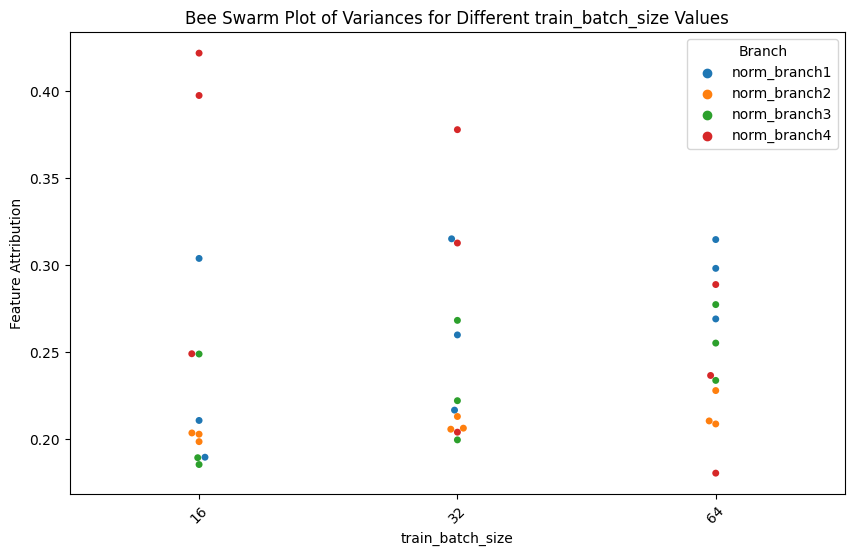

In [39]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(FA_SD, hyperparam, variables)

# Paired T test

In [40]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [41]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [42]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [43]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [44]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003], 'train_batch_size': [64, 32, 16]}

In [45]:
def get_significant_results(df, hyperparams_choice_list):
  if not baseline:
    values_to_compare=['std_norm_conv1x1','std_norm_conv1x1_3x3','std_norm_conv1x1_5x5','avg_std']
  else:
    values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [46]:
get_significant_results(FA_SD, hyperparams_choice_list)

#layer feature attribution rank frequency comparison

In [47]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [48]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-48-799ba4b3762b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


2314    22
3214    18
4213    16
1324    16
3124    14
1234    13
2134    12
4231    11
2143    10
3142    10
4132     8
4123     7
1423     6
3241     3
2431     3
1243     2
1432     2
4312     2
2413     2
3412     1
2341     1
3421     1
Name: rank_combination, dtype: int64